In [2]:
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
from itertools import chain
import fiona
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from shapely.prepared import prep
%matplotlib inline

In [3]:
tree = etree.parse("data/london_20131229.xml")
root = tree.getroot()

output = dict()
output["raw"]=[]
output["crs"]=[]
output["lon"]=[]
output["lat"]=[]

for each in root.xpath("plaque/geo"):
    #chack what we got back
    output["crs"].append(each.get('reference_system'))
    output["lat"].append(each.get('latitude'))
    output["lon"].append(each.get('longitude'))
    #go back upto plaque
    r = each.getparent().xpath('inscription/raw')[0]
    if isinstance(r.text,str):
        output['raw'].append(r.text.lstrip().rstrip())
    else:
        output['raw'].append(None)           

In [4]:
df = pd.DataFrame(output)
df = df.replace({'raw':0},None)
df = df.dropna()
df[["lon","lat"]]=df[["lon","lat"]].astype(float)

In [5]:
shp = fiona.open("data/london_wards.shp")
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0],bds[1])
ur = (bds[2],bds[3])
coords = list(chain(ll,ur))
w,h = coords[2]-coords[0],coords[3]-coords[1]
w,h

(0.8443906332745678, 0.4051139537590416)

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f5f705a8890>)

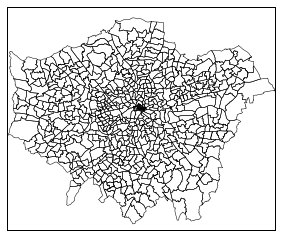

In [6]:
m = Basemap(
    projection = 'tmerc',
    lon_0=-2.0,
    lat_0=49.,
    ellps='WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True   
)
m.readshapefile(
    "data/london_wards",
    "london",
    color=None,
    zorder=2
)

In [7]:
df_map = pd.DataFrame({
        'poly':[Polygon(xy) for xy in m.london],
        'ward_name':[ward['NAME'] for ward in m.london_info]})
df_map['area_m']=df_map['poly'].map(lambda x: x.area)
df_map['area_km']=df_map['area_m']/1000000

map_points = pd.Series(
    [Point(m(mapped_x,mapped_y)) for mapped_x,mapped_y in zip(df['lon'],df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
df_map.head(2)

,poly,ward_name,area_m,area_km
0,"POLYGON ((13004.06946679378 5643.556704930117,...",Chessington South Ward,7557384.100912,7.557384
1,"POLYGON ((14432.57909461121 10890.80719812433,...",Tolworth and Hook Rise Ward,2596590.441811,2.596590


In [8]:
df_map["area_km"].sum()

1595.8798719132617

In [9]:
ldn_points = filter(wards_polygon.contains,plaque_points)

In [12]:
wards_polygon.contains(plaque_points)

False

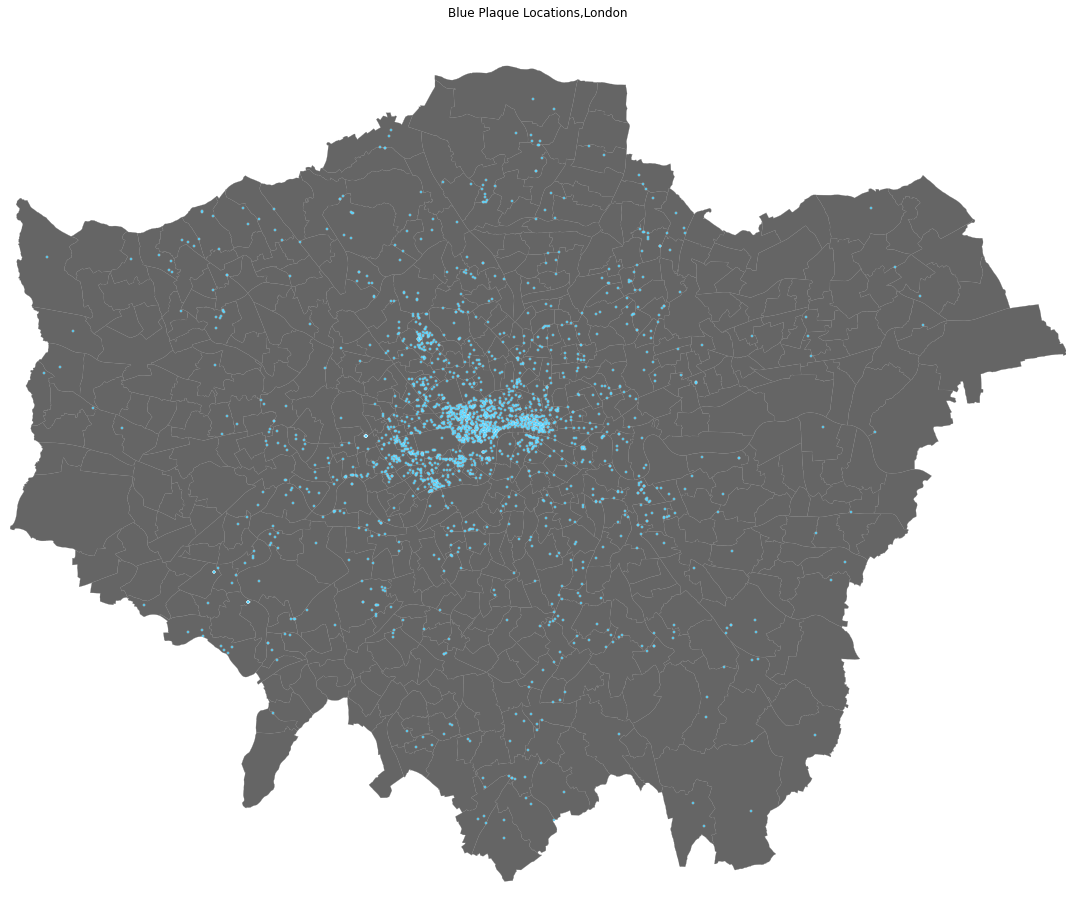

In [10]:
df_map['patches']=df_map["poly"].map(lambda x: PolygonPatch(
    x,
    fc="#555555",
    ec="#787878",
    lw=0.25,alpha=.9,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111,axisbg='w',frame_on=False)

dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    5,marker='o',lw=.25,
    facecolor='#33ccff',edgecolor='w',
    alpha=0.9,antialiased=True,
    label='Blue Plaque Locations',zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values,match_original=True))

plt.title("Blue Plaque Locations,London")
plt.tight_layout()
fig.set_size_inches(25, 14)
plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
plt.show()